# <center> Analyse de la concentration de CO2 <center>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interpolate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"    
# ‘all’|’last’|’last_expr’|’none’
#https://jupyter-console.readthedocs.io/en/4.0.1/config_options.html
pd.options.display.max_rows = 10

Nous récupérons les données les plus récentes sur le site en pointant sur un fichier au format .csv, si cette récupération est possible nous enregistrons une copie de ce fichier. Si pour une raison quelconque nous n'arrivons pas a faire ce téléchargement, nous travaillons sur le dernières données téléchargé.

In [2]:
try:
    raw_data = pd.read_csv("https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/"
                           "in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv",skiprows=56)
except OSError as err:
    print("Erreur lors du téléchargement : {0}".format(err))
    print("Nous téléchargeons les dernières données enregistrer sur notre PC")
    raw_data = pd.read_csv("monthly_in_situ_co2_mlo")
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise
else:
    raw_data.to_csv('monthly_in_situ_co2_mlo',index=True)

print(raw_data.shape)
raw_data

(756, 10)


Excel                 [ppm]      [ppm]         [ppm]  \
0    1958    1     21200   1958.0411    -99.99      -99.99       -99.99   
1    1958    2     21231   1958.1260    -99.99      -99.99       -99.99   
2    1958    3     21259   1958.2027    315.70      314.44       316.19   
3    1958    4     21290   1958.2877    317.45      315.16       317.30   
4    1958    5     21320   1958.3699    317.51      314.71       317.86   
..    ...  ...       ...         ...       ...         ...          ...   
751  2020    8     44058   2020.6230    -99.99      -99.99       -99.99   
752  2020    9     44089   2020.7077    -99.99      -99.99       -99.99   
753  2020   10     44119   2020.7896    -99.99      -99.99       -99.99   
754  2020   11     44150   2020.8743    -99.99      -99.99       -99.99   
755  2020   12     44180   2020.9563    -99.99      -99.99       -99.99   

         [ppm]         [ppm]      [ppm].1  
0       -99.99        -99.99       -99.99  
1       -99.99        -99.99       -99.99  
2       314.91        315.70       314.44  
3       314.99        317.45       315.16  
4       315.06        317.51       314.71  
..         ...           ...          ...  
751     -99.99        -99.99       -99.99  
752     -99.99        -99.99       -99.99  
753     -99.99        -99.99       -99.99  
754     -99.99        -99.99       -99.99  
755     -99.99        -99.99       -99.99  

[756 rows x 10 columns]

Nous voyons que les noms des colonnes ne sont pas très représentatives, nous modifions  les noms des colonnes

In [3]:
raw_data_1 = raw_data.copy()
print(raw_data.columns)
raw_data_1.columns = ['Yr','Mn','Date 1','Date 2','s1','s2','s3','s4','s5','s6']

Index(['    ', '   ', '   Excel', '          ', '   [ppm]', '    [ppm] ',
       '      [ppm]', '    [ppm]', '       [ppm]', '    [ppm].1'],
      dtype='object')


In [4]:
raw_data_1.head()

Yr  Mn  Date 1     Date 2      s1      s2      s3      s4      s5      s6
0  1958   1   21200  1958.0411  -99.99  -99.99  -99.99  -99.99  -99.99  -99.99
1  1958   2   21231  1958.1260  -99.99  -99.99  -99.99  -99.99  -99.99  -99.99
2  1958   3   21259  1958.2027  315.70  314.44  316.19  314.91  315.70  314.44
3  1958   4   21290  1958.2877  317.45  315.16  317.30  314.99  317.45  315.16
4  1958   5   21320  1958.3699  317.51  314.71  317.86  315.06  317.51  314.71

Les données vide sont représentés par la valeur -99.99, nous remplaçons cette valeur par une valeur plus adéquate NaN dans une autre DataFrame

In [5]:
date = datetime.date.today()
data = raw_data_1.copy()
data = data.drop(data[(data.Yr == date.year) & (data.Mn > date.month)].index)
data = data.replace(-99.99,np.NaN);
d = data[(data.Yr == date.year)].index
i,k = d[0], d[-1]

while k>=i:
    if data.loc[k].isnull().any():
        data = data.drop(k)
    else:
        break
    k = k - 1
    
annee, mois  = data.Yr[0], data.Mn[0]
d = data[(data.Yr == annee)].index
i,k = d[0], d[-1]

while i<=k:
    if data.loc[i].isnull().any():
        data = data.drop(i)
    else:
        break
    i = i + 1
InteractiveShell.ast_node_interactivity = "all"     
data.head(3)
data.tail(3)
InteractiveShell.ast_node_interactivity = "last_expr"  

On visualise les lignes dont une donnée colonne est manquante.

In [6]:
data[data.isnull().any(axis=1)]

Yr  Mn  Date 1     Date 2  s1  s2      s3      s4      s5      s6
5   1958   6   21351  1958.4548 NaN NaN  317.24  315.14  317.24  315.14
9   1958  10   21473  1958.7890 NaN NaN  312.44  315.40  312.44  315.40
73  1964   2   23422  1964.1257 NaN NaN  320.01  319.36  320.01  319.36
74  1964   3   23451  1964.2049 NaN NaN  320.74  319.41  320.74  319.41
75  1964   4   23482  1964.2896 NaN NaN  321.83  319.45  321.83  319.45

In [7]:
data.head()

Yr  Mn  Date 1     Date 2      s1      s2      s3      s4      s5      s6
2  1958   3   21259  1958.2027  315.70  314.44  316.19  314.91  315.70  314.44
3  1958   4   21290  1958.2877  317.45  315.16  317.30  314.99  317.45  315.16
4  1958   5   21320  1958.3699  317.51  314.71  317.86  315.06  317.51  314.71
5  1958   6   21351  1958.4548     NaN     NaN  317.24  315.14  317.24  315.14
6  1958   7   21381  1958.5370  315.86  315.19  315.86  315.22  315.86  315.19

On ajoute un index 'périod' à la DataFrame, cet index représente la période de mesure. 
Cette date est mise dans au format compréhensible par pandas. On visualise toutes les lignes qui seront supprimées.

In [8]:
df = data.dropna().copy()
df = df.reset_index().copy()
#print(data.shape)
period = [datetime.date(y,m,1) for y,m in zip(df['Yr'],df['Mn'])]
period = pd.Series(period,name = 'period')
#print(period.shape)
df = pd.concat([df,period],axis=1)
df = df.set_index('period') 
df.head()

index    Yr  Mn  Date 1     Date 2      s1      s2      s3  \
period                                                                   
1958-03-01      2  1958   3   21259  1958.2027  315.70  314.44  316.19   
1958-04-01      3  1958   4   21290  1958.2877  317.45  315.16  317.30   
1958-05-01      4  1958   5   21320  1958.3699  317.51  314.71  317.86   
1958-07-01      6  1958   7   21381  1958.5370  315.86  315.19  315.86   
1958-08-01      7  1958   8   21412  1958.6219  314.93  316.19  314.00   

                s4      s5      s6  
period                              
1958-03-01  314.91  315.70  314.44  
1958-04-01  314.99  317.45  315.16  
1958-05-01  315.06  317.51  314.71  
1958-07-01  315.22  315.86  315.19  
1958-08-01  315.29  314.93  316.19

Représentation graphique de la concentration  de CO2 de 1958 à nos jours

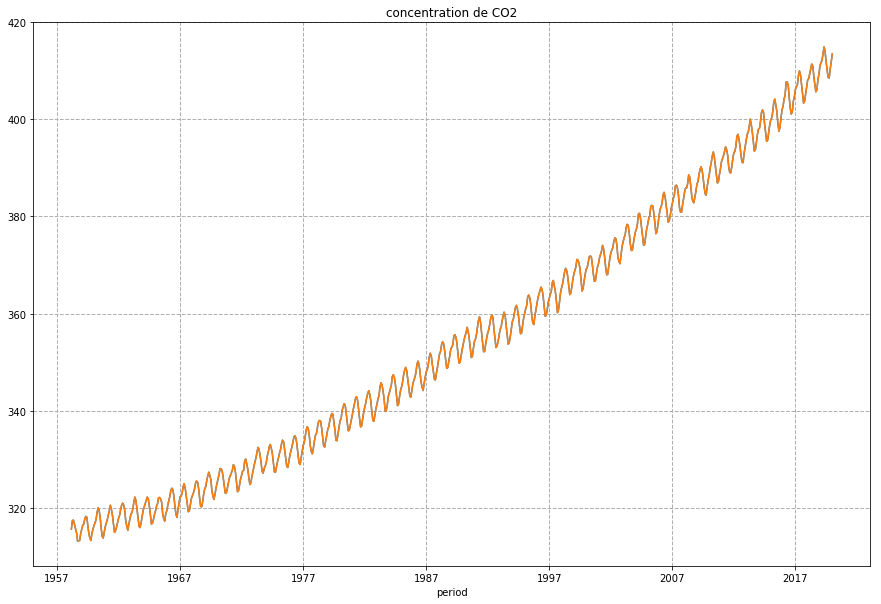

In [9]:
df['s1'].plot(title = 'concentration de CO2',);
df['s1'].plot(figsize=(15, 10),).grid(linestyle='--', linewidth=1);

Nous allons approximé la concentration de CO2 avec une droite $a*x+b$, puis faire la différence pour 
n'obtenir que les variations de la concentration de CO2.

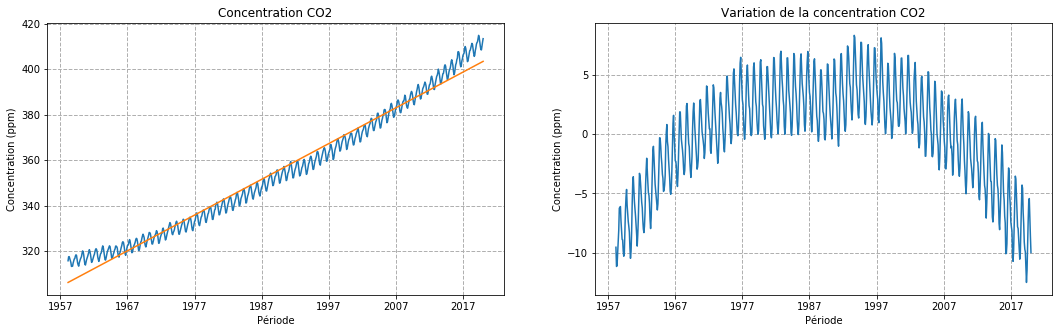

In [10]:
from scipy import stats

a, b, r_value, p_value, std_err = stats.linregress(df['Date 2'], df['s1'])
def predict(x):
    return a*x+b

data_lineaire = df.copy()
data_lineaire['reg_lineaire'] = predict(data_lineaire['Date 2'])

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)
#plot(figsize=(8, 5))  .plot(figsize=(15, 10), grid=True).grid(linestyle='--', linewidth=1);

ax1.set(title = 'Concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax1.plot(data_lineaire['s1'])
#data1['s1'].plot()
ax1.plot(data_lineaire['reg_lineaire']) 
data_lineaire['co2'] = data_lineaire['reg_lineaire']-data_lineaire['s1']
ax2.set(title = 'Variation de la concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax2.plot(data_lineaire['co2']); 

Le résultat n'est pas satisfaisant ...
Nous pouvons faire une optimisation avec une fonction de la forme $a*(x-b)^2+c$

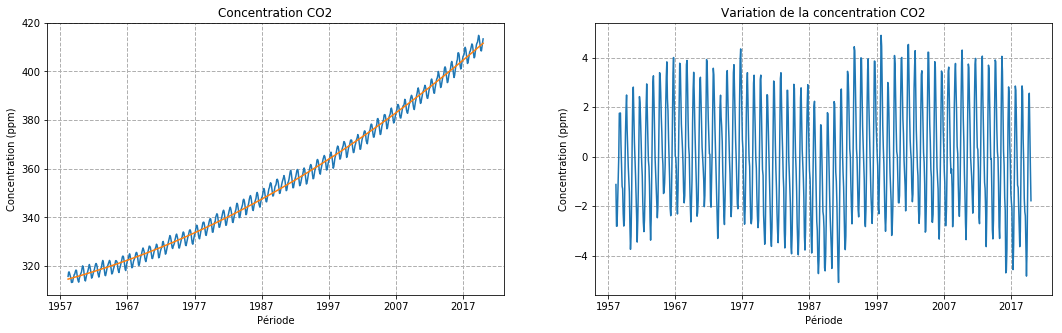

In [11]:
from scipy.optimize import curve_fit

def func_cube(x,a,b,c):
    return a*(x-b)**(2)+c

data_cube = df.copy()
popt, pcov = curve_fit(func_cube,data_cube['Date 2'],data_cube['s1'])

def fcube(x):
    return popt[0]*(x- popt[1])**(2)+popt[2]

data_cube['reg_cube'] = fcube(data_cube['Date 2'])

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)

ax1.set(title = 'Concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax1.plot(data_cube['s1'])
ax1.plot(data_cube['reg_cube']) 
data_cube['co2'] = data_cube['reg_cube']-data_cube['s1']
ax2.set(title = 'Variation de la concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax2.plot(data_cube['co2']); 

Nous recherchons l'oscillation lente, pour cela nous allons opéré en 2 etapes :
- Recherche de la fréquence lente, par FFT. Pour cela nous devons faire une interpolation pour les quelque points manquant. Ce qui nous donnera une gamme de fréquence possible (échantillonne de la FFT)
- Pour la gamme de fréquence spécifiées, nous  estimons tous les paramètres pour une approximation sinusoïdale (moyenne, amplitude et phase) par les moindres carrés ordinaires 


In [12]:
df = data.reset_index().copy()
df['period'] = pd.Series([datetime.date(y,m,1) for y,m in zip(df['Yr'],df['Mn'])])
df = df.set_index('period')   
df.head()
d = df[df.isnull().any(axis=1)]
d

index    Yr  Mn  Date 1     Date 2  s1  s2      s3      s4  \
period                                                                   
1958-06-01      5  1958   6   21351  1958.4548 NaN NaN  317.24  315.14   
1958-10-01      9  1958  10   21473  1958.7890 NaN NaN  312.44  315.40   
1964-02-01     73  1964   2   23422  1964.1257 NaN NaN  320.01  319.36   
1964-03-01     74  1964   3   23451  1964.2049 NaN NaN  320.74  319.41   
1964-04-01     75  1964   4   23482  1964.2896 NaN NaN  321.83  319.45   

                s5      s6  
period                      
1958-06-01  317.24  315.14  
1958-10-01  312.44  315.40  
1964-02-01  320.01  319.36  
1964-03-01  320.74  319.41  
1964-04-01  321.83  319.45

In [13]:
df.tail()

index    Yr  Mn  Date 1     Date 2      s1      s2      s3  \
period                                                                   
2019-09-01    740  2019   9   43723  2019.7068  408.55  412.06  408.52   
2019-10-01    741  2019  10   43753  2019.7890  408.43  412.07  408.67   
2019-11-01    742  2019  11   43784  2019.8740  410.28  412.56  410.29   
2019-12-01    743  2019  12   43814  2019.9562  411.85  412.78  411.88   
2020-01-01    744  2020   1   43845  2020.0410  413.37  413.33  413.11   

                s4      s5      s6  
period                              
2019-09-01  412.05  408.55  412.06  
2019-10-01  412.29  408.43  412.07  
2019-11-01  412.54  410.28  412.56  
2019-12-01  412.79  411.85  412.78  
2020-01-01  413.05  413.37  413.33

Pour les valeur manquantes, nous allons faire une interpolation linéaire afin que la FFT dispose de données prisent à échantillonnage de 1 mois.

In [14]:
df = df.interpolate(method='linear', limit_direction='forward',limit=3)
df

index    Yr  Mn  Date 1     Date 2       s1      s2      s3  \
period                                                                    
1958-03-01      2  1958   3   21259  1958.2027  315.700  314.44  316.19   
1958-04-01      3  1958   4   21290  1958.2877  317.450  315.16  317.30   
1958-05-01      4  1958   5   21320  1958.3699  317.510  314.71  317.86   
1958-06-01      5  1958   6   21351  1958.4548  316.685  314.95  317.24   
1958-07-01      6  1958   7   21381  1958.5370  315.860  315.19  315.86   
...           ...   ...  ..     ...        ...      ...     ...     ...   
2019-09-01    740  2019   9   43723  2019.7068  408.550  412.06  408.52   
2019-10-01    741  2019  10   43753  2019.7890  408.430  412.07  408.67   
2019-11-01    742  2019  11   43784  2019.8740  410.280  412.56  410.29   
2019-12-01    743  2019  12   43814  2019.9562  411.850  412.78  411.88   
2020-01-01    744  2020   1   43845  2020.0410  413.370  413.33  413.11   

                s4      s5      s6  
period                              
1958-03-01  314.91  315.70  314.44  
1958-04-01  314.99  317.45  315.16  
1958-05-01  315.06  317.51  314.71  
1958-06-01  315.14  317.24  315.14  
1958-07-01  315.22  315.86  315.19  
...            ...     ...     ...  
2019-09-01  412.05  408.55  412.06  
2019-10-01  412.29  408.43  412.07  
2019-11-01  412.54  410.28  412.56  
2019-12-01  412.79  411.85  412.78  
2020-01-01  413.05  413.37  413.33  

[743 rows x 11 columns]

In [15]:
d = df[(df.Yr >= 1964) & (df.Yr < 1965)]
d

index    Yr  Mn  Date 1     Date 2        s1        s2      s3  \
period                                                                       
1964-01-01     72  1964   1   23391  1964.0410  319.5700  319.5300  319.37   
1964-02-01     73  1964   2   23422  1964.1257  320.2425  319.4975  320.01   
1964-03-01     74  1964   3   23451  1964.2049  320.9150  319.4650  320.74   
1964-04-01     75  1964   4   23482  1964.2896  321.5875  319.4325  321.83   
1964-05-01     76  1964   5   23512  1964.3716  322.2600  319.4000  322.34   
...           ...   ...  ..     ...        ...       ...       ...     ...   
1964-08-01     79  1964   8   23604  1964.6230  318.6900  320.0000  318.24   
1964-09-01     80  1964   9   23635  1964.7077  316.7100  319.6500  316.64   
1964-10-01     81  1964  10   23665  1964.7896  316.8700  319.9100  316.59   
1964-11-01     82  1964  11   23696  1964.8743  317.6800  319.5800  317.76   
1964-12-01     83  1964  12   23726  1964.9563  318.7100  319.4900  318.89   

                s4      s5      s6  
period                              
1964-01-01  319.32  319.57  319.53  
1964-02-01  319.36  320.01  319.36  
1964-03-01  319.41  320.74  319.41  
1964-04-01  319.45  321.83  319.45  
1964-05-01  319.49  322.26  319.40  
...            ...     ...     ...  
1964-08-01  319.58  318.69  320.00  
1964-09-01  319.60  316.71  319.65  
1964-10-01  319.62  316.87  319.91  
1964-11-01  319.64  317.68  319.58  
1964-12-01  319.66  318.71  319.49  

[12 rows x 11 columns]

In [16]:
data_cube = df.copy()
popt, pcov = curve_fit(func_cube,data_cube['Date 2'],data_cube['s1'])
data_cube['reg_cube'] = fcube(data_cube['Date 2'])
data_cube['co2'] = data_cube['reg_cube']-data_cube['s1']

nb = len(data_cube['Date 2'])
ecart = []
for i in np.arange(0,nb-1):
    ecart.append(data_cube['Date 2'][i+1] - data_cube['Date 2'][i])
dt = np.mean(ecart)
dt
data_cube.co2.mean()

1.6731473990043244e-11

Utilisation de la fonction np.fft.fft pour transformer le signal temporel en signal fréquentiel à l’aide de la transformée de Fourier rapide. Le résultat s1_fft est un tableau de nombres complexes. La densité spectrale de puissance est calculée à l’aide de la formule Γx=|X|2T. Les fréquences sont ensuite calculées à l’aide de la fonction np.fft.fftfreq.

0.016150740242261104


<StemContainer object of 3 artists>

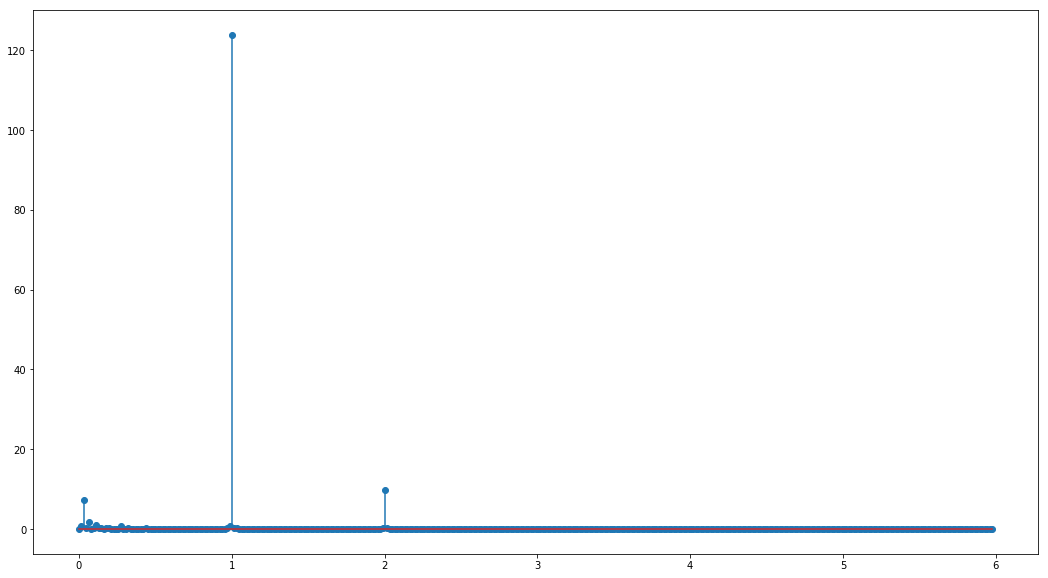

In [58]:
s1 = data_cube.co2 - data_cube.co2.mean()

# calcul de la transformee de Fourier et des frequences
s1_fft = np.fft.fft(s1)

n = s1.size
dt = 1/12
pds_s1 = (dt/n) * np.abs(s1_fft)**2  # densité spectral de puissance
freq = np.fft.fftfreq(n, d=dt)       # fréquences associées

f1 = 1/(n*dt)
print(f1)

freq = freq[:int(n/2)]
pds_s1 = pds_s1[:int(n/2)]
# affichage de la transformee de Fourier
plt.figure(figsize=(18, 10))
plt.stem(freq, pds_s1, label="PSD")

Finalement, seules les « moitiés droites » des tableaux sont conservées car les gauches contiennent les fréquences négatives. Ces opérations sont réalisées àl’aide duslicingpython (tranchage)

In [59]:
indide_f = np.where(pds_s1 > 5)
f_lente = indide_f[0][0] * f1
indide_f = np.where(pds_s1 > 20)
f_rapide = indide_f[0][-1] * f1
                    
print(f' Estimation de la frequence lente : {f_lente} \n Esitmation de la fréquence rapide : {f_rapide}')

 Estimation de la frequence lente : 0.03230148048452221 
 Esitmation de la fréquence rapide : 1.0013458950201883


In [93]:
def my_sin(x, f, amplitude, phase, offset):
    return np.sin(x * f * 2 * np.pi + phase) * amplitude + offset

f0 = f_lente   
ampl0= 1
phase0 = 0
offset0 = 0

p0 = [f0,ampl0,phase0,offset0]
x = np.array(data_cube['Date 2'])
popt, pcov = curve_fit(my_sin, x , s1, p0 = p0)
print(popt)
ylent = my_sin(x,popt[0],popt[1],popt[2],popt[3])

f0 = f_rapide  
ampl0= 3.5
p0 = [f0,ampl0,phase0,offset0]
popt, pcov = curve_fit(my_sin, x , s1, p0 = p0)
print(popt)
yrapide = my_sin(x,popt[0],popt[1],popt[2],popt[3])  
 

[ 2.94277009e-02 -7.53030446e-01  3.62086915e+01 -6.66058624e-02]
[1.0004524  2.84337318 3.40502984 0.00947134]


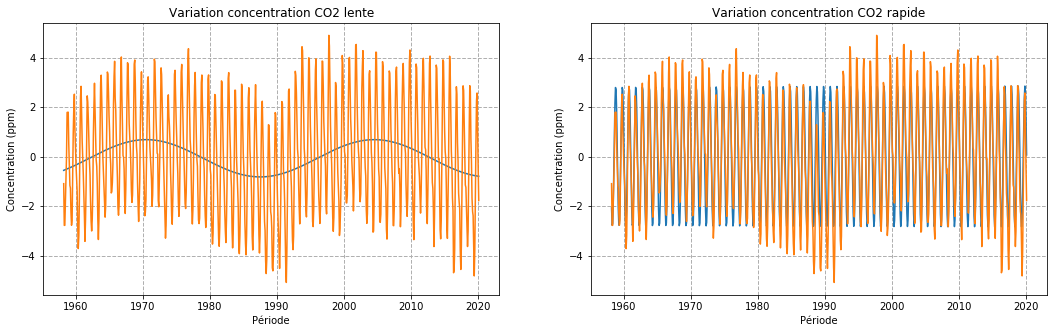

In [94]:
fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)

ax1.set(title = 'Variation concentration CO2 lente',xlabel='Période',ylabel='Concentration (ppm)')
ax1.plot(x,ylent,x,s1)
ax2.set(title = 'Variation concentration CO2 rapide',xlabel='Période',ylabel='Concentration (ppm)')
ax2.plot(x,yrapide,x,s1)